# Мэтчинг товаров
Задачи:
- разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base;
- оценить качество алгоритма по метрике accuracy@5.
*деплой: разработать REST API сервис, который по предложенным данным будем предлагать несколько похожих товаров.

🔹 Ссылка на датасет: 

https://disk.yandex.ru/d/BBEphK0EHSJ5Jw

🔺 Описание:

- base.csv - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.

- train.csv - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов).

- validation.csv - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv

- validation_answer.csv - правильные ответы к предыдущему файлу

## Импортирование

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
base_full = pd.read_csv('/Users/artemmm/Downloads/data/base.csv')
base = base_full.copy()
train = pd.read_csv('/Users/artemmm/Downloads/data/train.csv')
validation_answer = pd.read_csv('/Users/artemmm/Downloads/data/validation_answer.csv')
validation = pd.read_csv('/Users/artemmm/Downloads/data/validation.csv')

## EDA

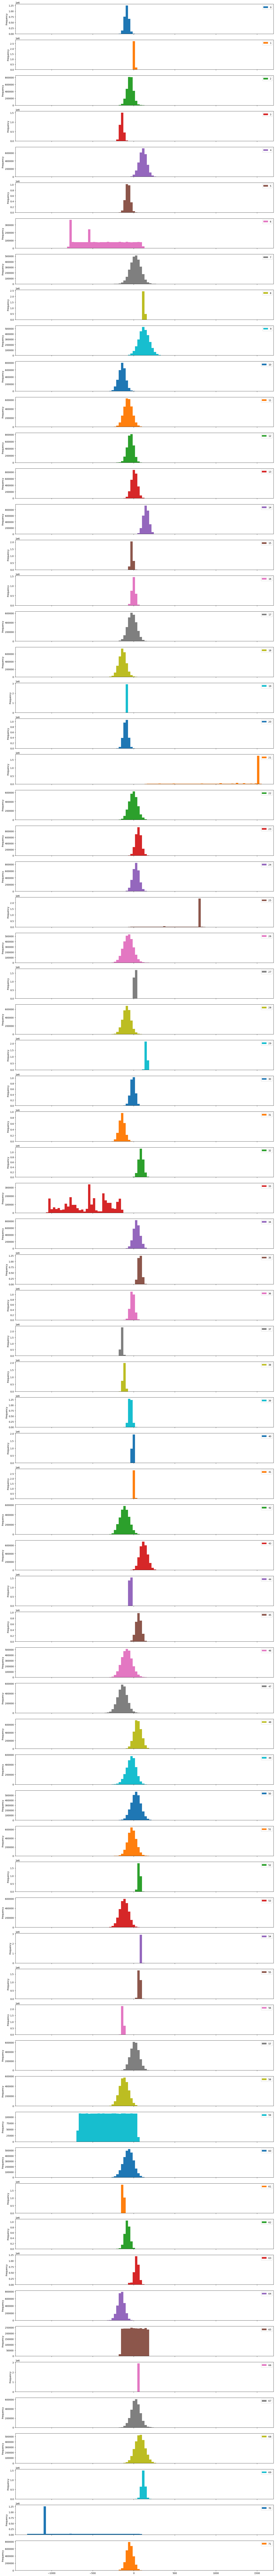

In [3]:
base.plot(kind = 'hist', figsize = (20,200), subplots = True, bins = 100);

In [4]:
#70, 33, 6, 19, 21, 25, 40,41 ,54,55, 59 удалим, тк ненормальное распределение

In [5]:
train = train.drop(['8','33','70', '19', '25', '40', '54', '59', '66', '6', '27', '44', '65', '21', '29', '41', 
                    '52', '56', '61'], axis = 1)
base = base.drop(['8','33','70', '19', '25', '40', '54', '59', '66', '6', '27', '44', '65', '21', '29', '41', 
                    '52', '56', '61'], axis = 1)

validation = validation.drop(['8','33','70', '19', '25', '40', '54', '59', '66', '6', '27', '44', '65', '21', '29', '41', 
                    '52', '56', '61'], axis = 1)

In [6]:
train = train.set_index(['Id'])
base = base.set_index(['Id'])
validation = validation.set_index(['Id'])

**ROBUST SCALER**

In [7]:
targets = train['Target']
train = train.drop('Target', axis = 1)
#scaler = RobustScaler()
#scaler.fit(base)
#base_sc = scaler.transform(base)
#train_sc = scaler.transform(train)
#base = pd.DataFrame(base_sc, columns = base.columns)
#train = pd.DataFrame(train_sc, columns = train.columns)

#acc@5 = 0 with minmax scaler

In [8]:
#base_norm = preprocessing.MinMaxScaler().fit_transform(base.values)

после преобразований Robust'ом метрика падает с 69 до 0. Проблему не нашел.

## Рассчёт кол-ва кластеров методом Локтя

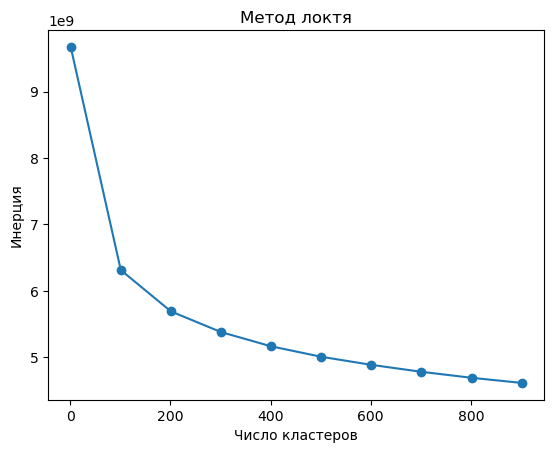

In [9]:
X = base.sample(n=100000, random_state=42)
inertia = []
for k in range(1, 1000,100):
    kmeans = KMeans(n_clusters=k,  n_init=10,random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

#Визуализация метода локтя
plt.plot(range(1, 1000,100), inertia, marker='o')
plt.title('Метод локтя')
plt.xlabel('Число кластеров')
plt.ylabel('Инерция')
plt.show()

## Разработка системы с помощью FAISS

**Train**

In [10]:
import faiss
import numpy as np

In [11]:
k = 200
dimension = base.shape[1]
quantizer = faiss.IndexFlatL2(dimension)
index = faiss.IndexFlatL2(dimension)
index.nprobe = 5
index.reset()
index.train(np.ascontiguousarray(base.values[:,:]).astype('float32'))
index.add(np.ascontiguousarray(base.values[:,:]).astype('float32'))
base_index = {k: v for k, v in enumerate(base.index.to_list())}
r, idx = index.search(np.ascontiguousarray(train.values).astype('float32'), 5)
acc = 0 
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
    
print(100 * acc / len(idx))

69.638


Почему именно l2? хотел сам произвести сравнение, но парень в чате нашей мастерской сделал это первее меня, его исследование показало, что FlatL2 показывает наилучшие результаты. Т.к. время на исходе, добавлю это позже в тетрадь.

**Validation**

In [12]:
validation_answer = validation_answer.drop('Id', axis = 1)
base_index = {k: v for k, v in enumerate(base.index.to_list())}
r, idx = index.search(np.ascontiguousarray(validation.values).astype('float32'), 5)
acc = 0
for target, el in zip(validation_answer['Expected'].values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
    
print(100 * acc / len(idx))

69.524


In [13]:
from IPython.display import Audio
import numpy as np

beep = np.sin(2*np.pi*400*np.arange(30000*2)/10000)
Audio(beep, rate=10000, autoplay=True)

**Итог:**
- Был проведен EDA признаков перед разработкой системы.
- Был проведен подсчет оптимального количества кластеров методом локтя.
- Был проведен выбор наилучшей модели для системы рекомендаций. Лучшая: FlatL2.
- Была обучена и протестирована система рекомендаций. Метрика на трейне: 69,6.
- Система была протестирована на валидационной выборке. Метрика на валидации: 69,5.

Привет. Подскажи пожалуйста, что делать с РобустСкейлером? И как выполнять доп.пункт задания - REST API. Т.к. я студент, и у меня сессия, не успел разобраться с заданием, но как время появится, очень хотелось бы сделать этот пункт. 